<a href="https://colab.research.google.com/github/Valquire/ATOp/blob/main/ATOp-Predictive-Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predictive Model of the Autonomy of Military Naval Platform**
This notebook compiles and organizes the code generated for the analysis of the autonomy of an naval platform of the Brazilian Navy, using data collected between 2013 and 2017.

In [ ]:
!pip install kaleido
!pip install ImbalancedLearningRegression
!pip install streamlit

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    VotingRegressor,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

import ImbalancedLearningRegression as iblr

## **Integrate Historical Data from Military Naval Platform**

### **Loading Data**

In [ ]:
# access to Google Drive
from google.colab import drive
drive.mount('/content/GoogleDrive')

Drive already mounted at /content/GoogleDrive; to attempt to forcibly remount, call drive.mount("/content/GoogleDrive", force_remount=True).


In [ ]:
# load the SINGRA Dataset
df_Singra = pd.read_csv('/content/GoogleDrive/MyDrive/Projeto/Dados/SINGRA/RMC_MEIO1.csv',
                        sep=',', header=0, parse_dates=['PERIODO'],
                        dtype={'QTDE_ITENS_RM': np.float64, 'PRECO_UNITARIO_VENDA': np.float64})

In [ ]:
# load the RFC Dataset
df_RFC = pd.read_csv('/content/GoogleDrive/MyDrive/Projeto/Dados/RFC/RFC.csv',
                        sep=',', header=0)#, dtype={'MILHAS': np.float64})


### **Data Exploration**

In [ ]:
# Scrub SINGRA dataset

df_Singra.head(5)

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,DESCRICAO_CLG,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA
0,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,ÓLEO DIESEL MARÍTIMO,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,229000.0,NaN
1,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,ÓLEO DIESEL MARÍTIMO,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,230000.0,NaN
2,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,ÓLEO DIESEL MARÍTIMO,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,120000.0,NaN
3,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190010170,LOMBO EM PEDAÇOS,QUILOGRAMA,160.0,7.32
4,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015262,GELÉIA,QUILOGRAMA,36.0,3.40


In [ ]:
df_Singra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ANO                   1826 non-null   int64         
 1   PERIODO               1826 non-null   datetime64[ns]
 2   MES                   1826 non-null   int64         
 3   SIGLA_OM              1826 non-null   object        
 4   RM_TYPE               1826 non-null   object        
 5   SITUACAO_RM           1826 non-null   object        
 6   DESC_SITUACAO_RM      1826 non-null   object        
 7   GRUPO_JURISDICAO      1826 non-null   object        
 8   DESCRICAO_CLG         1818 non-null   object        
 9   PI                    1826 non-null   object        
 10  NOME_PORTUGUES        1826 non-null   object        
 11  UF                    1826 non-null   object        
 12  QTDE_ITENS_RM         1826 non-null   float64       
 13  PRECO_UNITARIO_VEN

In [ ]:
df_Singra['GRUPO_JURISDICAO'].value_counts()

,count
GRUPO_JURISDICAO,
SUBSISTENCIA,1478
COMBUSTIVEIS,348


In [ ]:
# Remove consumable items outside the scope of work
df_Singra = df_Singra.drop(df_Singra.loc[lambda df_GENEROS: ((df_Singra.NOME_PORTUGUES == 'REFEIÇÃO INDIVIDUAL') |
                                                              (df_Singra.NOME_PORTUGUES == 'RAÇÃO DE SOBREVIVÊNCIA'))].index, axis=0)

In [ ]:
# Standardization of the Supply Unit (SU)
print('UF antes:')
print(df_Singra['UF'].value_counts())
print('\n')

# 1 Pack of coffee = 0.5 kilogram
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*0.5 if x.UF == 'PACOTE'
                                             else x.QTDE_ITENS_RM, axis = 1)
# change the description
df_Singra['UF'] = df_Singra.UF.replace('PACOTE', 'QUILOGRAMA')

# 1 Bottle of vegetable oil = 0.9 liter
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*0.9 if x.UF == 'GARRAFA'
                                             else x.QTDE_ITENS_RM, axis = 1)
df_Singra['UF'] = df_Singra.UF.replace('GARRAFA', 'LITRO') # change the description

# 1 US Quarter Gallon of lubricant = 0.946353 liter
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*0.946353 if x.UF == 'QUARTO DE GALAO AMERICANO'
                                             else x.QTDE_ITENS_RM, axis = 1)
# 1 drum of lubricant = 200 liters
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*200 if x.UF == 'TAMBOR'
                                             else x.QTDE_ITENS_RM, axis = 1)

# 1 Gallon of lubricant = 3.785412 liters
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*3.785412 if x.UF == 'GALAO'
                                             else x.QTDE_ITENS_RM, axis = 1)

# 1 Bucket of lubricant = 20 liters
# 1 Bucket of grease = 20 kilograms
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*20 if x.UF == 'BALDE'
                                             else x.QTDE_ITENS_RM, axis = 1)
# 1 Can of grease = 5 kilograms
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*5 if x.UF == 'LATA'
                                             else x.QTDE_ITENS_RM, axis = 1)

# Change UF description for Lubricant and Grease
df_Singra['UF'] = df_Singra.apply(lambda x: 'LITRO' if x.DESCRICAO_CLG == 'LUBRIFICANTE'
                                  else 'QUILOGRAMA' if x.DESCRICAO_CLG == 'GRAXA' else x.UF, axis = 1)

print('UF depois:')
print(df_Singra['UF'].value_counts())

UF antes:
UF
QUILOGRAMA                   1247
LITRO                         421
BALDE                          58
TAMBOR                         49
GARRAFA                        35
GALAO                           6
QUARTO DE GALAO AMERICANO       3
PACOTE                          3
LATA                            1
Name: count, dtype: int64


UF depois:
UF
QUILOGRAMA    1260
LITRO          563
Name: count, dtype: int64


In [ ]:
df_CLG = df_Singra.query('GRUPO_JURISDICAO == "COMBUSTIVEIS"')

In [ ]:
df_CLG['DESCRICAO_CLG'].value_counts()

,count
DESCRICAO_CLG,
LUBRIFICANTE,114
ÓLEO DIESEL MARÍTIMO,90
ÓLEO DIESEL ESPECIAL - OCMT,81
COMBUSTÍVEL AVIAÇÃO - QAV-5,34
GRAXA,14
GASOLINA COMUM,7


In [ ]:
# Remove consumable items outside the scope of work
df_CLG = df_CLG.drop(df_CLG.loc[lambda df_CLG: ((df_CLG.DESCRICAO_CLG == 'COMBUSTÍVEL AVIAÇÃO - QAV-5')
                                                | (df_CLG.DESCRICAO_CLG == 'GASOLINA COMUM'))].index, axis=0)

In [ ]:
df_CLG['DESCRICAO_CLG'].value_counts()

,count
DESCRICAO_CLG,
LUBRIFICANTE,114
ÓLEO DIESEL MARÍTIMO,90
ÓLEO DIESEL ESPECIAL - OCMT,81
GRAXA,14


In [ ]:
# Standardization of the description of CLG types
df_CLG['DESCRICAO_CLG'] = df_CLG.DESCRICAO_CLG.replace('ÓLEO DIESEL ESPECIAL - OCMT', 'COMBUSTIVEL')
df_CLG['DESCRICAO_CLG'] = df_CLG.DESCRICAO_CLG.replace('ÓLEO DIESEL MARÍTIMO', 'COMBUSTIVEL')

In [ ]:
df_CLG['DESCRICAO_CLG'].value_counts()

,count
DESCRICAO_CLG,
COMBUSTIVEL,171
LUBRIFICANTE,114
GRAXA,14


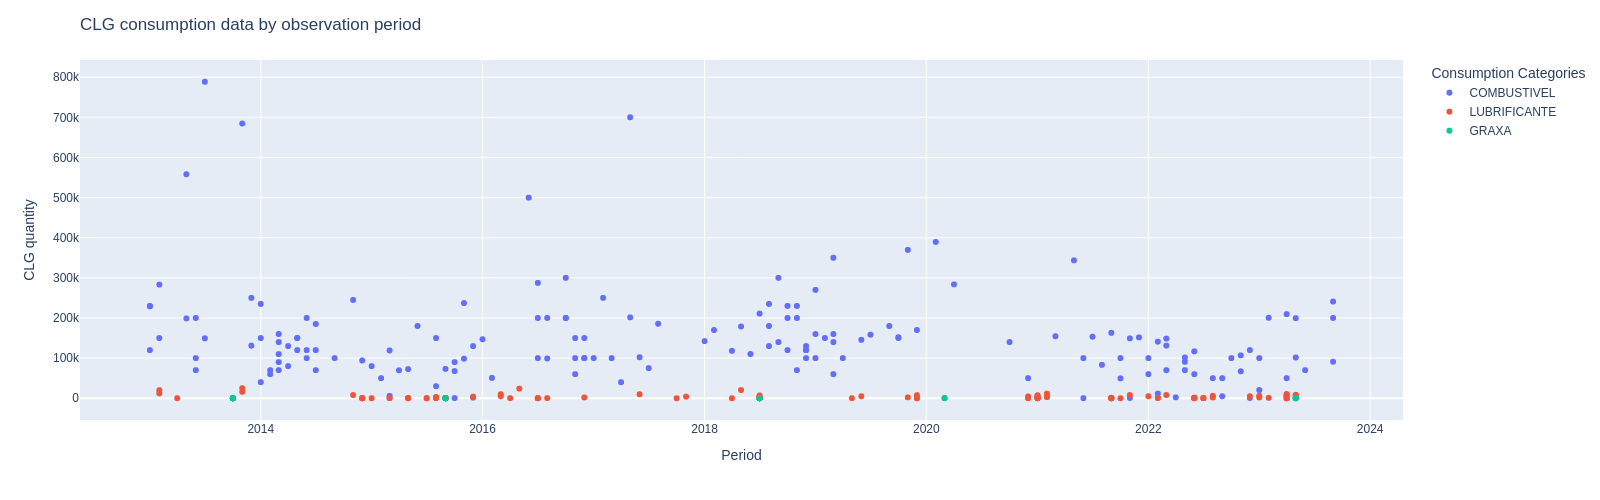

In [ ]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)
# plotly code
fig1 = px.scatter(df_CLG, x = df_CLG.PERIODO,
                  y = df_CLG.QTDE_ITENS_RM,
                  color=df_CLG.DESCRICAO_CLG)
fig1.update_layout(
    title='CLG consumption data by observation period',
    xaxis_title='Period',
    yaxis_title='CLG quantity',
    legend_title='Consumption Categories',
)
fig1.show(renderer='png', width=1600, height=500)

In [ ]:
grupoCLG = df_CLG.groupby('DESCRICAO_CLG')
grupoCLG.first()

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA
DESCRICAO_CLG,,,,,,,,,,,,,
COMBUSTIVEL,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,229000.0,2.14
GRAXA,2013,2013-10-01,10,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,190025257,GRAXA DE FINALIDADE GERAL,QUILOGRAMA,20.0,181.67
LUBRIFICANTE,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,190035158,ÓLEO LUBRIFICANTE DE TURBINA DE VAPOR,LITRO,12000.0,1449.90


In [ ]:
grupoCLG.get_group('COMBUSTIVEL')

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,DESCRICAO_CLG,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA
0,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,229000.0,NaN
1,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,230000.0,NaN
2,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,120000.0,NaN
5,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL COMBUSTÍVEL,LITRO,150000.0,2.14
20,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024044,ÓLEO DIESEL COMBUSTÍVEL,LITRO,283093.0,2.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1805,2023,2023-05-01,5,MEIO1,RMC,SNL,FORNECIDA SEM NL PATRIMONIAL,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL COMBUSTÍVEL,LITRO,101475.0,5.27
1816,2023,2023-06-01,6,MEIO1,RMC,SNL,FORNECIDA SEM NL PATRIMONIAL,COMBUSTIVEIS,COMBUSTIVEL,190024044,ÓLEO DIESEL COMBUSTÍVEL,LITRO,69983.0,8.14
1823,2023,2023-09-01,9,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,200000.0,NaN
1824,2023,2023-09-01,9,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,241000.0,NaN


In [ ]:
# Method to transform groups into columns
pivot_df_CLG = df_CLG.pivot_table(values='QTDE_ITENS_RM', index='PERIODO', columns='DESCRICAO_CLG', aggfunc='sum')

# Display the resulting DataFrame
# print(pivot_df_CLG)

In [ ]:
df_GENEROS = df_Singra.query('GRUPO_JURISDICAO == "SUBSISTENCIA"')

In [ ]:
df_GENEROS['NOME_PORTUGUES'].value_counts()

,count
NOME_PORTUGUES,
AÇÚCAR REFINADO,79
ÓLEO VEGETAL,77
ARROZ DESCASCADO,73
COXA DE FRANGO,70
LEITE INTEGRAL EM PÓ,67
FEIJÕES PRETOS SECOS,64
FILE PEITO FRANGO,63
GELÉIA,61
SUCO CAJU,56


Food Group, based on the Brazilian food pyramid (PHILIPPI et al., 1999)
The pyramid is made up of 8 food groups:

1.   Rice, bread, pasta, potatoes, cassava;
2.   Vegetables;
1.   Fruits;
2.   Meat and eggs;
1.   Milk, cheese and yogurt;
2.   Beans and oilseeds;
1.   Oils and fats;
2.   Sugars and sweets.









In [ ]:
# 02 categories were included, DRINKS (tea, coffee, etc.) and SEASONING (pepper, salt, etc.)
# Even though they are not part of the food pyramid, there were records of consumption of these items
GRUPO_ALIMENTO = []

for i in df_GENEROS.itertuples():
  valor = i.NOME_PORTUGUES

  if valor == 'AÇÚCAR REFINADO':
    GRUPO_ALIMENTO.append('ACUCARES')

  elif valor == 'ÓLEO VEGETAL':
    GRUPO_ALIMENTO.append('OLEOS_GORDURAS')

  elif valor == 'ARROZ DESCASCADO':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'COXA DE FRANGO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'LEITE INTEGRAL EM PÓ':
    GRUPO_ALIMENTO.append('LEITE_QUEIJO')

  elif valor == 'FEIJÕES PRETOS SECOS':
    GRUPO_ALIMENTO.append('FEIJOES')

  elif valor == 'FILE PEITO FRANGO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'GELÉIA':
    GRUPO_ALIMENTO.append('ACUCARES')

  elif valor == 'SUCO CAJU':
    GRUPO_ALIMENTO.append('FRUTAS')

  elif valor == 'MOLHO DE TOMATE':
    GRUPO_ALIMENTO.append('LEGUMES_VERDURAS')

  elif valor == 'FARINHA MANDIOCA':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'CREME DE LEITE':
    GRUPO_ALIMENTO.append('LEITE_QUEIJO')

  elif valor == 'PATINHO ESPECIAL BOVINO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'AZEITE DE OLIVA':
    GRUPO_ALIMENTO.append('OLEOS_GORDURAS')

  elif valor == 'BIFE DO ALCATRA COM PICANHA BOVINO SEM OSSO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'SUCO MARACUJA':
    GRUPO_ALIMENTO.append('FRUTAS')

  elif valor == 'LOMBO DESOSSADO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'ESPAGUETE':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'BISCOITO CRACKER DE TRIGO':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'LOMBO EM PEDAÇOS':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'BISCOITO DE AÇÚCAR':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'CHÃ DESOSSADO SEM MÚSCULO OU PONTA BOVINO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'MACARRÃO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'CACAU EM PÓ PARA BEBIDA':
    GRUPO_ALIMENTO.append('ACUCARES')

  elif valor == 'PERNIL DESOSSADO E AMARRADO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'BIFE DE CONTRA-FILÉ DO LOMBO BOVINO DESOSSADO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'FILÉ MIGNON COMPLETO DE CARNE BOVINA':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'FILEZINHO PEITO FRANGO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'ACÉM BOVINO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'BIFES DE CARNE BOVINA':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'BIFE DE FILÉ DE CARNE BOVINA SEM OSSO ESPECIAL':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'SUCO DE UVA ENLATADO':
    GRUPO_ALIMENTO.append('FRUTAS')

  elif valor == 'FEIJÃO-PINTO SECO':
    GRUPO_ALIMENTO.append('FEIJOES')

  elif valor == 'ARROZ PARBOILIZADO':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'BIFE BOVINO EM CUBOS ESPECIAL':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'BEBIDA COM SABOR DE FRUTA':
    GRUPO_ALIMENTO.append('FRUTAS')

  elif valor == 'ARROZ MARROM':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'CAFÉ TORRADO':
    GRUPO_ALIMENTO.append('BEBIDAS')

  else:
    GRUPO_ALIMENTO.append('TEMPEROS')

# Add Food Group column
df_GENEROS.insert(14, 'GRUPO_ALIMENTO', GRUPO_ALIMENTO)

df_GENEROS.head()

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,DESCRICAO_CLG,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA,GRUPO_ALIMENTO
3,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190010170,LOMBO EM PEDAÇOS,QUILOGRAMA,160.00,7.32,CARNES
4,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015262,GELÉIA,QUILOGRAMA,36.00,3.40,ACUCARES
7,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190008021,ESPAGUETE,QUILOGRAMA,100.00,1.75,ARROZ_MASSA
8,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190010176,LOMBO DESOSSADO,QUILOGRAMA,151.98,9.49,CARNES
9,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190007993,LEITE INTEGRAL EM PÓ,QUILOGRAMA,104.00,9.95,LEITE_QUEIJO


In [ ]:
df_GENEROS['GRUPO_ALIMENTO'].value_counts()

,count
GRUPO_ALIMENTO,
CARNES,485
ARROZ_MASSA,246
ACUCARES,164
OLEOS_GORDURAS,120
LEITE_QUEIJO,119
FRUTAS,109
FEIJOES,68
TEMPEROS,56
LEGUMES_VERDURAS,55


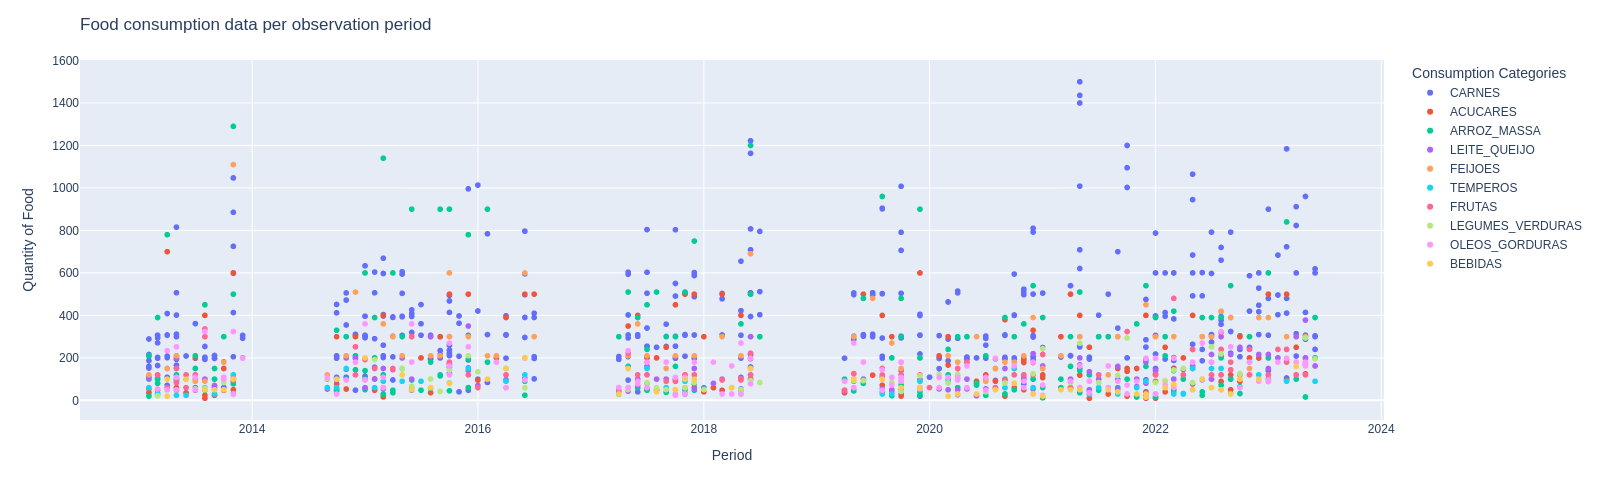

In [ ]:
fig1 = px.scatter(df_GENEROS, x = df_GENEROS.PERIODO,
                  y = df_GENEROS.QTDE_ITENS_RM,
                  color=df_GENEROS.GRUPO_ALIMENTO)
fig1.update_layout(
    title='Food consumption data per observation period',
    xaxis_title='Period',
    yaxis_title='Quantity of Food',
    legend_title='Consumption Categories',
)
fig1.show(renderer='png', width=1600, height=500)

In [ ]:
# Method to transform groups into columns
pivot_df_GENEROS = df_GENEROS.pivot_table(values='QTDE_ITENS_RM', index='PERIODO', columns='GRUPO_ALIMENTO', aggfunc='sum')

# Display the resulting DataFrame
# print(pivot_df_GENEROS)

In [ ]:
grupoGENEROS = df_GENEROS.groupby('GRUPO_ALIMENTO')
grupoGENEROS.first()

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,DESCRICAO_CLG,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA
GRUPO_ALIMENTO,,,,,,,,,,,,,,
ACUCARES,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015262,GELÉIA,QUILOGRAMA,36.00,3.40
ARROZ_MASSA,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190008021,ESPAGUETE,QUILOGRAMA,100.00,1.75
BEBIDAS,2013,2013-04-01,4,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190032164,CAFÉ TORRADO,QUILOGRAMA,20.00,12.43
CARNES,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190010170,LOMBO EM PEDAÇOS,QUILOGRAMA,160.00,7.32
FEIJOES,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190009728,FEIJÕES PRETOS SECOS,QUILOGRAMA,120.00,2.84
FRUTAS,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,120.00,4.67
LEGUMES_VERDURAS,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015107,MOLHO DE TOMATE,QUILOGRAMA,21.76,2.10
LEITE_QUEIJO,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190007993,LEITE INTEGRAL EM PÓ,QUILOGRAMA,104.00,9.95
OLEOS_GORDURAS,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190008110,ÓLEO VEGETAL,LITRO,54.00,3.34


In [ ]:
grupoGENEROS.get_group('FRUTAS')

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,DESCRICAO_CLG,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA,GRUPO_ALIMENTO
31,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,120.0,4.67,FRUTAS
32,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015044,SUCO MARACUJA,LITRO,120.0,2.44,FRUTAS
50,2013,2013-04-01,4,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,60.0,4.67,FRUTAS
81,2013,2013-05-01,5,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,150.0,4.67,FRUTAS
86,2013,2013-05-01,5,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,84.0,2.88,FRUTAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757,2023,2023-04-01,4,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015061,SUCO DE UVA ENLATADO,LITRO,120.0,5.31,FRUTAS
1763,2023,2023-04-01,4,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,120.0,3.19,FRUTAS
1783,2023,2023-05-01,5,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,168.0,3.19,FRUTAS
1800,2023,2023-05-01,5,MEIO1,RMC,SNL,FORNECIDA SEM NL PATRIMONIAL,SUBSISTENCIA,* SEM TIPO CLG *,190015044,SUCO MARACUJA,LITRO,120.0,8.10,FRUTAS


In [ ]:
# Concatenates the CLG and GENEROS dataframes
df_Singra_T = pd.concat([pivot_df_CLG, pivot_df_GENEROS], axis=1)
# Impute the mean for unknown values
df_Singra_T = df_Singra_T.fillna(df_Singra_T.mean())

In [ ]:
# Includes the PERIOD index as a dataframe column
df_Singra_T = df_Singra_T.rename_axis('PERIODO').reset_index()

In [ ]:
df_Singra_T.head()

,PERIODO,COMBUSTIVEL,GRAXA,LUBRIFICANTE,ACUCARES,ARROZ_MASSA,BEBIDAS,CARNES,FEIJOES,FRUTAS,LEGUMES_VERDURAS,LEITE_QUEIJO,OLEOS_GORDURAS,TEMPEROS
0,2013-01-01,579000.000000,75.6,7504.373609,339.076552,573.195349,76.27451,1864.602824,286.190476,245.258065,111.867636,186.931646,207.162162,84.777778
1,2013-02-01,433093.000000,75.6,32000.000000,90.000000,330.000000,76.27451,1642.203000,120.000000,245.258065,111.867636,104.000000,207.162162,60.000000
2,2013-03-01,262525.589474,75.6,7504.373609,150.000000,626.000000,76.27451,1846.950000,286.190476,240.000000,21.760000,186.931646,54.000000,30.000000
3,2013-04-01,262525.589474,75.6,140.000000,759.400000,943.600000,120.00000,1662.200000,210.000000,60.000000,111.867636,150.000000,284.000000,60.000000
4,2013-05-01,756866.000000,75.6,7504.373609,308.000000,838.400000,76.27451,3151.660000,300.000000,318.000000,111.867636,351.200000,410.000000,114.000000


In [ ]:
# Add the ANO column
ano = []
for i in df_Singra_T.itertuples():
  ano.append(i.PERIODO.year)

df_Singra_T.insert(loc=1, column='ANO', value=ano)

In [ ]:
# Add the TRIMESTRE column
trimestre =[]
for i in df_Singra_T.itertuples():
  if i.PERIODO.month <= 3:
    trimestre.append(1)
  elif i.PERIODO.month <= 6:
    trimestre.append(2)
  elif i.PERIODO.month <= 9:
    trimestre.append(3)
  else:
    trimestre.append(4)

df_Singra_T.insert(loc=2, column='TRIMESTRE', value=trimestre)

In [ ]:
df_Singra_T.head(10)

,PERIODO,ANO,TRIMESTRE,COMBUSTIVEL,GRAXA,LUBRIFICANTE,ACUCARES,ARROZ_MASSA,BEBIDAS,CARNES,FEIJOES,FRUTAS,LEGUMES_VERDURAS,LEITE_QUEIJO,OLEOS_GORDURAS,TEMPEROS
0,2013-01-01,2013,1,579000.000000,75.6,7504.373609,339.076552,573.195349,76.27451,1864.602824,286.190476,245.258065,111.867636,186.931646,207.162162,84.777778
1,2013-02-01,2013,1,433093.000000,75.6,32000.000000,90.000000,330.000000,76.27451,1642.203000,120.000000,245.258065,111.867636,104.000000,207.162162,60.000000
2,2013-03-01,2013,1,262525.589474,75.6,7504.373609,150.000000,626.000000,76.27451,1846.950000,286.190476,240.000000,21.760000,186.931646,54.000000,30.000000
3,2013-04-01,2013,2,262525.589474,75.6,140.000000,759.400000,943.600000,120.00000,1662.200000,210.000000,60.000000,111.867636,150.000000,284.000000,60.000000
4,2013-05-01,2013,2,756866.000000,75.6,7504.373609,308.000000,838.400000,76.27451,3151.660000,300.000000,318.000000,111.867636,351.200000,410.000000,114.000000
5,2013-06-01,2013,2,370000.000000,75.6,7504.373609,35.640000,100.000000,100.00000,208.910000,286.190476,180.000000,111.867636,186.931646,207.162162,24.000000
6,2013-07-01,2013,3,937915.000000,75.6,7504.373609,253.460000,510.000000,76.27451,971.461000,180.000000,120.000000,54.400000,100.000000,158.000000,84.777778
7,2013-08-01,2013,3,262525.589474,75.6,7504.373609,434.000000,646.000000,50.00000,1148.200000,90.000000,636.000000,56.000000,100.000000,374.000000,60.000000
8,2013-09-01,2013,3,262525.589474,75.6,7504.373609,23.760000,250.000000,50.00000,607.100000,286.190476,245.258065,111.867636,130.200000,207.162162,30.000000
9,2013-10-01,2013,4,262525.589474,151.0,1360.000000,197.520000,300.000000,50.00000,350.600000,180.000000,245.258065,84.000000,100.000000,208.000000,84.777778


In [ ]:
# Sums values ​​based on ANO and TRIMESTRE
df_SINGRA_TRIM = df_Singra_T.groupby(['ANO', 'TRIMESTRE'])[['COMBUSTIVEL', 'GRAXA',	'LUBRIFICANTE',	'ACUCARES',	'ARROZ_MASSA',
                                                            'BEBIDAS',	'CARNES',	'FEIJOES',	'FRUTAS',	'LEGUMES_VERDURAS',
                                                            'LEITE_QUEIJO',	'OLEOS_GORDURAS',	'TEMPEROS']].sum()
df_SINGRA_TRIM.head()

COMBUSTIVEL  GRAXA  LUBRIFICANTE     ACUCARES  ARROZ_MASSA  \
ANO  TRIMESTRE                                                                
2013 1          1.274619e+06  226.8  47008.747218   579.076552  1529.195349   
     2          1.389392e+06  226.8  15148.747218  1103.040000  1882.000000   
     3          1.462966e+06  226.8  22513.120827   711.220000  1406.000000   
     4          1.328019e+06  302.2  49864.373609  1276.596552  2620.000000   
2014 1          1.125000e+06  226.8  22513.120827  1017.229655  1719.586047   

                   BEBIDAS       CARNES      FEIJOES       FRUTAS  \
ANO  TRIMESTRE                                                      
2013 1          228.823529  5353.755824   692.380952   730.516129   
     2          296.274510  5022.770000   796.190476   558.000000   
     3          176.274510  2726.761000   556.190476  1001.258065   
     4          226.274510  5423.980000  1576.190476   688.516129   
2014 1          228.823529  5593.808473   858.571429   735.774194   

                LEGUMES_VERDURAS  LEITE_QUEIJO  OLEOS_GORDURAS    TEMPEROS  
ANO  TRIMESTRE                                                              
2013 1                245.495273    477.863291      468.324324  174.777778  
     2                335.602909    688.131646      901.162162  198.000000  
     3                222.267636    330.200000      739.162162  174.777778  
     4                223.867636    389.531646      760.000000  289.555556  
2014 1                335.602909    560.794937      621.486486  254.333333

In [ ]:
# # Scrub RFC dataset
# Eliminates columns for concatenation
df_RFC = df_RFC.drop(['TV', 'DT_INICIO', 'DT_FIM', 'OPERACAO', 'PORTOS'], axis=1)

In [ ]:
df_RFC.head()

,ANO,TRIMESTRE,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
0,NaN,NaN,243,NaN,2.5,400.49,2.5
1,NaN,NaN,243,NaN,1.5,196.00,2.0
2,NaN,NaN,243,NaN,3.5,433.64,1.5
3,NaN,NaN,243,NaN,2.5,1504.59,5.5
4,NaN,NaN,243,NaN,1.5,1698.57,6.5


In [ ]:
# Deletes record columns NaN
df_RFC = df_RFC.dropna()
df_RFC.reset_index(drop=True, inplace=True)

In [ ]:
df_RFC.head()

,ANO,TRIMESTRE,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
0,2013.0,1.0,227,32.0,18.0,9220.96,40.0
1,2013.0,2.0,205,33.0,16.5,6914.57,41.5
2,2013.0,3.0,184,74.5,2.0,4871.69,15.5
3,2013.0,4.0,222,59.5,7.0,6240.00,25.5
4,2014.0,1.0,261,0.0,34.5,13629.25,55.5


In [ ]:
# adjust types
df_RFC['ANO'] = df_RFC.ANO.astype('int64')
df_RFC['TRIMESTRE'] = df_RFC.TRIMESTRE.astype('int64')

<ipython-input-40-c531dcaf684d>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-40-c531dcaf684d>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_RFC.head()

,ANO,TRIMESTRE,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
0,2013,1,227,32.0,18.0,9220.96,40.0
1,2013,2,205,33.0,16.5,6914.57,41.5
2,2013,3,184,74.5,2.0,4871.69,15.5
3,2013,4,222,59.5,7.0,6240.00,25.5
4,2014,1,261,0.0,34.5,13629.25,55.5


In [ ]:
# Defines the columns ANO and TRIMESTRE as indexes
df_RFC = df_RFC.set_index(['ANO', 'TRIMESTRE'])

In [ ]:
df_RFC.head()

MILITARES  DIAS_PORTO_SEDE  DIAS_PORTO_FORA_SEDE    MILHAS  \
ANO  TRIMESTRE                                                               
2013 1                227             32.0                  18.0   9220.96   
     2                205             33.0                  16.5   6914.57   
     3                184             74.5                   2.0   4871.69   
     4                222             59.5                   7.0   6240.00   
2014 1                261              0.0                  34.5  13629.25   

                DIAS_MAR  
ANO  TRIMESTRE            
2013 1              40.0  
     2              41.5  
     3              15.5  
     4              25.5  
2014 1              55.5

In [ ]:
# Concatenates the SINGRA_TRIM and RFC dataframes
df_Endurance = pd.concat([df_SINGRA_TRIM, df_RFC], axis=1)

In [ ]:
df_Endurance.head()

COMBUSTIVEL  GRAXA  LUBRIFICANTE     ACUCARES  ARROZ_MASSA  \
ANO  TRIMESTRE                                                                
2013 1          1.274619e+06  226.8  47008.747218   579.076552  1529.195349   
     2          1.389392e+06  226.8  15148.747218  1103.040000  1882.000000   
     3          1.462966e+06  226.8  22513.120827   711.220000  1406.000000   
     4          1.328019e+06  302.2  49864.373609  1276.596552  2620.000000   
2014 1          1.125000e+06  226.8  22513.120827  1017.229655  1719.586047   

                   BEBIDAS       CARNES      FEIJOES       FRUTAS  \
ANO  TRIMESTRE                                                      
2013 1          228.823529  5353.755824   692.380952   730.516129   
     2          296.274510  5022.770000   796.190476   558.000000   
     3          176.274510  2726.761000   556.190476  1001.258065   
     4          226.274510  5423.980000  1576.190476   688.516129   
2014 1          228.823529  5593.808473   858.571429   735.774194   

                LEGUMES_VERDURAS  LEITE_QUEIJO  OLEOS_GORDURAS    TEMPEROS  \
ANO  TRIMESTRE                                                               
2013 1                245.495273    477.863291      468.324324  174.777778   
     2                335.602909    688.131646      901.162162  198.000000   
     3                222.267636    330.200000      739.162162  174.777778   
     4                223.867636    389.531646      760.000000  289.555556   
2014 1                335.602909    560.794937      621.486486  254.333333   

                MILITARES  DIAS_PORTO_SEDE  DIAS_PORTO_FORA_SEDE    MILHAS  \
ANO  TRIMESTRE                                                               
2013 1              227.0             32.0                  18.0   9220.96   
     2              205.0             33.0                  16.5   6914.57   
     3              184.0             74.5                   2.0   4871.69   
     4              222.0             59.5                   7.0   6240.00   
2014 1              261.0              0.0                  34.5  13629.25   

                DIAS_MAR  
ANO  TRIMESTRE            
2013 1              40.0  
     2              41.5  
     3              15.5  
     4              25.5  
2014 1              55.5

In [ ]:
# Inclui o index ANO e TRIMESTRE como coluna do dataframe
df_Endurance = df_Endurance.rename_axis(['ANO', 'TRIMESTRE']).reset_index()

In [ ]:
df_Endurance_rounder = df_Endurance.round(2)

In [ ]:
df_Endurance_rounder.head(10)

,ANO,TRIMESTRE,COMBUSTIVEL,GRAXA,LUBRIFICANTE,ACUCARES,ARROZ_MASSA,BEBIDAS,CARNES,FEIJOES,FRUTAS,LEGUMES_VERDURAS,LEITE_QUEIJO,OLEOS_GORDURAS,TEMPEROS,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
0,2013,1,1274618.59,226.8,47008.75,579.08,1529.20,228.82,5353.76,692.38,730.52,245.50,477.86,468.32,174.78,227.0,32.0,18.0,9220.96,40.0
1,2013,2,1389391.59,226.8,15148.75,1103.04,1882.00,296.27,5022.77,796.19,558.00,335.60,688.13,901.16,198.00,205.0,33.0,16.5,6914.57,41.5
2,2013,3,1462966.18,226.8,22513.12,711.22,1406.00,176.27,2726.76,556.19,1001.26,222.27,330.20,739.16,174.78,184.0,74.5,2.0,4871.69,15.5
3,2013,4,1328018.59,302.2,49864.37,1276.60,2620.00,226.27,5423.98,1576.19,688.52,223.87,389.53,760.00,289.56,222.0,59.5,7.0,6240.00,25.5
4,2014,1,1125000.00,226.8,22513.12,1017.23,1719.59,228.82,5593.81,858.57,735.77,335.60,560.79,621.49,254.33,261.0,0.0,34.5,13629.25,55.5
5,2014,2,1050000.00,226.8,22513.12,1017.23,1719.59,228.82,5593.81,858.57,735.77,335.60,560.79,621.49,254.33,261.0,0.0,41.0,10721.90,50.0
6,2014,3,475000.00,151.2,15008.75,392.54,633.20,152.55,1924.60,406.19,451.26,213.87,340.93,315.16,144.78,261.0,9.5,31.5,13145.04,51.0
7,2014,4,601491.59,226.8,16144.37,979.16,1237.60,252.55,4662.00,1006.19,862.52,335.60,497.20,306.00,294.78,196.0,79.5,3.0,1151.00,9.5
8,2015,1,255469.00,226.8,7980.08,1021.50,2798.80,352.55,6896.40,932.38,660.00,399.87,364.00,831.16,234.78,219.0,66.5,4.0,4041.05,19.5
9,2015,2,322166.00,226.8,15545.53,978.15,2240.40,246.27,7275.60,796.19,1139.26,330.27,686.73,954.32,409.56,240.0,61.0,3.5,5178.05,26.5


In [ ]:
# # Make figure
# fig, ax = plt.subplots(figsize=(11, 2))  # fit size

# # Remove axis
# ax.axis('off')

# # Add table
# ax.table(cellText=df_Endurance_rounder.values, colLabels=df_Endurance_rounder.columns, loc='center', cellLoc='center', colColours=['#f2f2f2']*len(df_Endurance_rounder.columns))

# # Save image PNG
# plt.savefig('saida_head.png', bbox_inches='tight', dpi=600)

In [ ]:
# Removes records outside the study period (2013 to 2017)
df_Endurance = df_Endurance.drop(df_Endurance.loc[lambda df_Endurance: df_Endurance.ANO > 2017].index, axis=0)
df_Endurance.reset_index(drop=True, inplace=True)

In [ ]:
# Correlation Matrix
matriz_correlacao = df_Endurance.corr(method="spearman")
matriz_correlacao.style.background_gradient(cmap="coolwarm")

,ANO,TRIMESTRE,COMBUSTIVEL,GRAXA,LUBRIFICANTE,ACUCARES,ARROZ_MASSA,BEBIDAS,CARNES,FEIJOES,FRUTAS,LEGUMES_VERDURAS,LEITE_QUEIJO,OLEOS_GORDURAS,TEMPEROS,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
ANO,1.000000,0.000000,-0.459855,-0.149215,-0.111204,0.107705,0.101550,0.166934,0.187715,-0.043115,-0.302839,-0.055945,0.052314,-0.154451,0.253784,0.128953,0.126169,-0.165735,-0.282044,-0.190216
TRIMESTRE,0.000000,1.000000,0.224914,-0.016654,-0.265698,0.233550,-0.101205,-0.301094,-0.108990,0.081804,0.003909,-0.342032,-0.046710,-0.164108,0.321014,-0.295160,0.210195,-0.147524,-0.255937,-0.263891
COMBUSTIVEL,-0.459855,0.224914,1.000000,0.308911,0.353040,0.141888,-0.194718,-0.128890,-0.153963,0.024925,0.073515,-0.184469,0.036227,-0.068184,-0.286920,-0.231928,-0.267172,0.207001,0.261654,0.188864
GRAXA,-0.149215,-0.016654,0.308911,1.000000,0.657226,0.482946,0.627721,0.409181,0.492669,0.588192,0.273406,0.246615,0.122087,0.439235,0.428123,-0.288895,0.050780,-0.078123,-0.191590,-0.191734
LUBRIFICANTE,-0.111204,-0.265698,0.353040,0.657226,1.000000,-0.044107,0.114069,0.121467,0.033460,0.264841,0.016037,0.037635,0.028898,0.097710,0.131549,-0.021245,-0.004563,-0.046266,-0.012122,-0.089464
ACUCARES,0.107705,0.233550,0.141888,0.482946,-0.044107,1.000000,0.536364,0.509138,0.754545,0.739955,-0.002282,0.340491,0.481818,0.258557,0.470865,-0.318217,-0.003030,0.068002,-0.166794,-0.064955
ARROZ_MASSA,0.101550,-0.101205,-0.194718,0.627721,0.114069,0.536364,1.000000,0.424662,0.653030,0.436695,-0.020540,0.436900,0.201515,0.771108,0.451817,0.003779,0.036364,-0.043068,-0.189435,-0.094411
BEBIDAS,0.166934,-0.301094,-0.128890,0.409181,0.121467,0.509138,0.424662,1.000000,0.563172,0.522091,-0.116928,0.566880,0.426184,0.209320,0.293915,-0.294616,0.301373,-0.216704,-0.476135,-0.345989
CARNES,0.187715,-0.108990,-0.153963,0.492669,0.033460,0.754545,0.653030,0.563172,1.000000,0.590599,0.232790,0.407824,0.487879,0.301143,0.536390,-0.064248,-0.065152,0.091425,-0.139624,-0.024925
FEIJOES,-0.043115,0.081804,0.024925,0.588192,0.264841,0.739955,0.436695,0.522091,0.590599,1.000000,0.149601,0.624069,0.490523,0.264080,0.558146,-0.166415,0.025777,0.128545,-0.157857,-0.128497


In [ ]:
df_Endurance.corr(method="spearman").DIAS_MAR.sort_values()

,DIAS_MAR
DIAS_PORTO_SEDE,-0.953932
TEMPEROS,-0.494512
BEBIDAS,-0.345989
TRIMESTRE,-0.263891
GRAXA,-0.191734
ANO,-0.190216
FEIJOES,-0.128497
OLEOS_GORDURAS,-0.124340
ARROZ_MASSA,-0.094411
LUBRIFICANTE,-0.089464


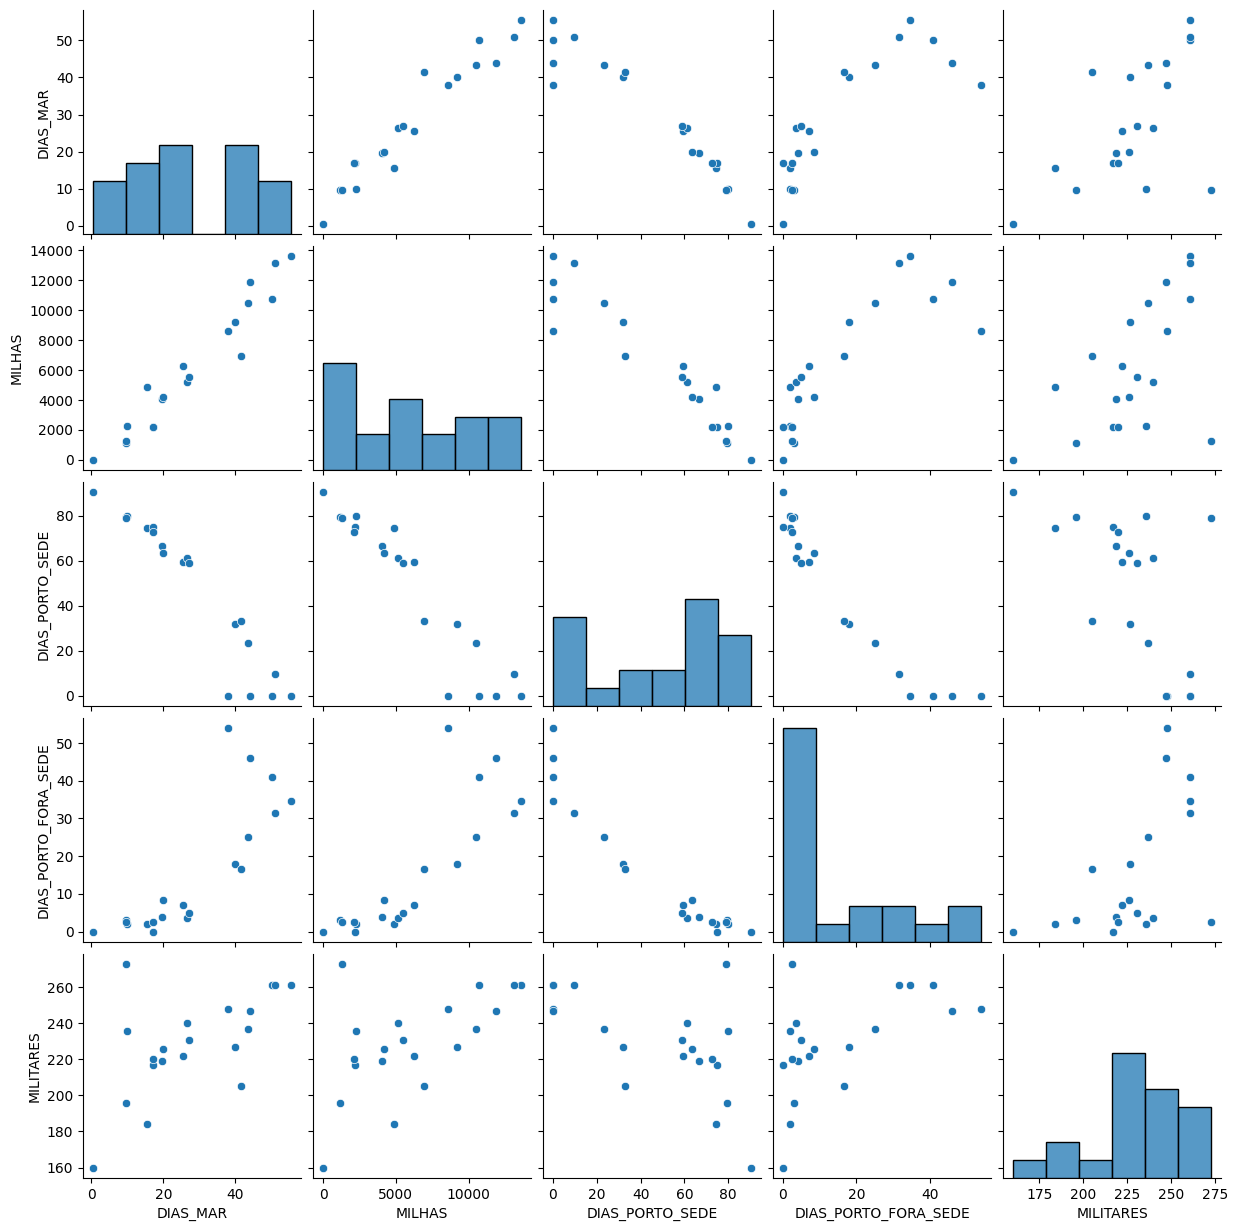

In [ ]:
sns.pairplot(df_Endurance[['DIAS_MAR', 'MILHAS', 'DIAS_PORTO_SEDE', 'DIAS_PORTO_FORA_SEDE', 'MILITARES']])

### **Data Preparation**

<Axes: ylabel='DIAS_MAR'>

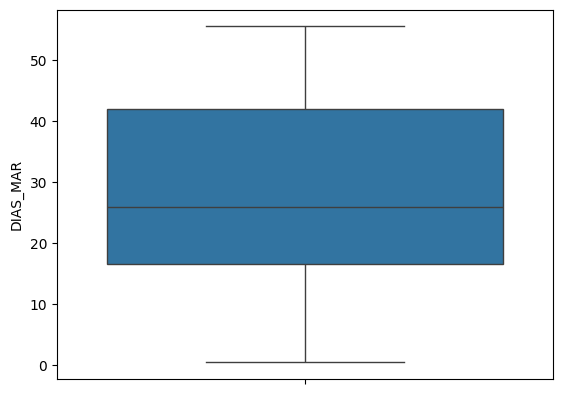

In [ ]:
sns.boxplot(df_Endurance['DIAS_MAR'])

In [ ]:
## specify phi relevance values
rg_mtrx_iblr = [

    [42,  1, 0],  ## over-sample ("minority")
    [30, 0, 0],  ## under-sample ("majority")
    [20, 0, 0],  ## under-sample
    [31, 0, 0],  ## under-sample
]

In [ ]:
## conduct Random Over-sampling

df_Endurance_RO = iblr.gn(
    data = df_Endurance, ## pandas dataframe
    y = 'DIAS_MAR',            ## string ('header name')
    pert = 0.02,              ## perturbation / noise percentage (pos real) #gaussian
    samp_method = 'extreme',   ## string ('balance' or 'extreme')
    drop_na_col = True,        ## boolean (True or False)
    drop_na_row = True,        ## boolean (True or False)
    replace = True,           ## boolean (True or False)
    manual_perc = True,      ## user defines percentage of under-sampling and over-sampling  # added
    perc_u = 0.9,              ## percentage of under-sampling  # added
    perc_o = 100,              ## percentage of over-sampling  # added

    ## phi relevance arguments
    rel_thres = 0.8,               ## real number (0 < R < 1)
    rel_method = 'manual',         ## string ('auto' or 'manual')
    # rel_xtrm_type = 'both',      ## unused (rel_method = 'manual')
    # rel_coef = 1.50,             ## unused (rel_method = 'manual')
    rel_ctrl_pts_rg = rg_mtrx_iblr ## 2d array (format: [x, y])
)


synth_matrix: 100%|##########| 5/5 [00:11<00:00,  2.22s/it]


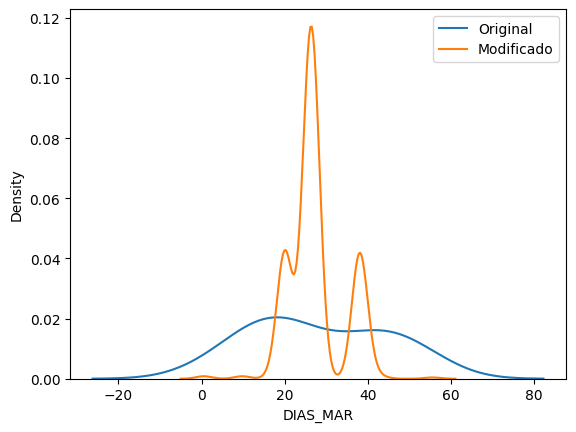

In [ ]:
## plot y distribution

sns.kdeplot(df_Endurance['DIAS_MAR'], label = 'Original')
sns.kdeplot(df_Endurance_RO['DIAS_MAR'], label = 'Modificado')
plt.legend(labels=['Original','Modificado'])


<Axes: ylabel='DIAS_MAR'>

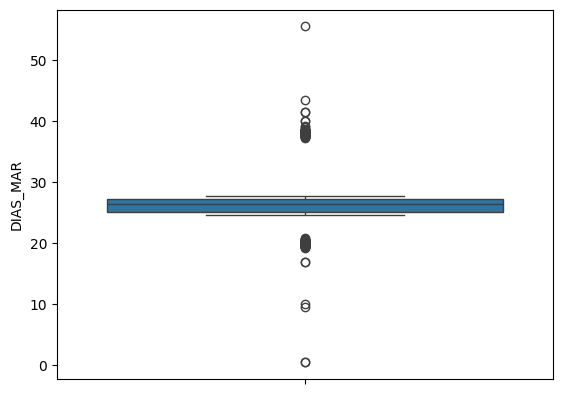

In [ ]:
sns.boxplot(df_Endurance_RO['DIAS_MAR'])

In [ ]:
# Prepare the data

# Target attribute

# original dataset
y = df_Endurance['DIAS_MAR']

# synthetic data
y_s = df_Endurance_RO['DIAS_MAR']

# Predictive attributes except dropped columns

# original dataset
X = df_Endurance.drop(['ANO', 'GRAXA', 'TRIMESTRE', 'MILHAS', 'DIAS_MAR'], axis=1)

# synthetic data
X_s = df_Endurance_RO.drop(['ANO', 'GRAXA', 'TRIMESTRE', 'MILHAS', 'DIAS_MAR'], axis=1)

In [ ]:
# Evaluation measures
def metricas(y_treino, predicoes_treino, y_teste, predicoes_teste):
    #r2 = (r2_score(y_teste, predicoes_teste)*100)
    r2 = r2_score(y_teste, predicoes_teste)
    rmse = np.sqrt(mean_squared_error(y_teste, predicoes_teste))
    #mae = mean_absolute_error(y_teste, predicoes_teste)
    #print(f'Coeficiente de Determinação (R²): {r2:.2f}%')
    print(f'Coeficiente de Determinação (R²): {r2:.2f}')
    #print(f'Erro Absoluto Médio (MAE): {mae:.0f}')
    print(f'Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}')
    print('-'*50)

    plt.scatter(predicoes_treino, y_treino, label='Train Samples', c='#d95f02')
    plt.scatter(predicoes_teste, y_teste, label='Test Samples', c='#7570b3')
    plt.xlabel('Predict Values')
    plt.ylabel('True Values')
    plt.legend()
    plt.plot([0, 50], [0, 50], c="g", zorder=0)  # linha diagonal cor verde
    plt.xlim([0, 50])
    plt.ylim([0, 50])
    plt.tight_layout()
    plt.show()

## **Training, Testing, and Validation**

### **Using Original Dataset**

#### **Train and Test Sets**

In [ ]:
# Separates training and testing sets
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=0)

# Normalization of predictive attributes
norm = StandardScaler()
X_treino_norm = norm.fit_transform(X_treino)
X_teste_norm = norm.transform(X_teste)

#print(X_teste_norm)
X_treino.head()

,COMBUSTIVEL,LUBRIFICANTE,ACUCARES,ARROZ_MASSA,BEBIDAS,CARNES,FEIJOES,FRUTAS,LEGUMES_VERDURAS,LEITE_QUEIJO,OLEOS_GORDURAS,TEMPEROS,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE
6,4.750000e+05,15008.747218,392.536552,633.195349,152.549020,1924.602824,406.190476,451.258065,213.867636,340.931646,315.162162,144.777778,261.0,9.5,31.5
13,1.024864e+06,31704.373609,1288.476552,1460.390698,426.274510,6553.502824,1172.380952,610.516129,282.535273,736.731646,561.162162,294.777778,160.0,90.5,0.0
4,1.125000e+06,22513.120827,1017.229655,1719.586047,228.823529,5593.808473,858.571429,735.774194,335.602909,560.794937,621.486486,254.333333,261.0,0.0,34.5
2,1.462966e+06,22513.120827,711.220000,1406.000000,176.274510,2726.761000,556.190476,1001.258065,222.267636,330.200000,739.162162,174.777778,184.0,74.5,2.0
5,1.050000e+06,22513.120827,1017.229655,1719.586047,228.823529,5593.808473,858.571429,735.774194,335.602909,560.794937,621.486486,254.333333,261.0,0.0,41.0


#### **Individual Estimators**

In [ ]:
# Creating the individual models
modelo_RL = make_pipeline(preprocessing.StandardScaler(), LinearRegression())
modelo_AD = make_pipeline(DecisionTreeRegressor(random_state=0))
modelo_RF = make_pipeline(RandomForestRegressor(max_depth=3, random_state=0))
modelo_GB = make_pipeline(preprocessing.StandardScaler(), GradientBoostingRegressor(random_state=0))
modelo_KN = make_pipeline(preprocessing.StandardScaler(), KNeighborsRegressor(n_neighbors=2))
modelo_SV = make_pipeline(preprocessing.StandardScaler(), SVR(kernel='linear'))
modelo_RN = make_pipeline(preprocessing.StandardScaler(), MLPRegressor(max_iter=1000, random_state=0))

# List of pipelines
pipelines = [
    modelo_RL,
    modelo_AD,
    modelo_RF,
    modelo_GB,
    modelo_KN,
    #modelo_SV,
    #modelo_RN
]

# Training and evaluating each pipeline
for pipeline in pipelines:
    # Training the pipeline on the training set
    pipeline.fit(X_treino, y_treino)

    # Predictions - test set
    predicoes = pipeline.predict(X_teste)

    # Evaluating performance using R² as an example metric
    #r2 = (r2_score(y_teste, predicoes)*100)
    r2 = r2_score(y_teste, predicoes)
    rmse = np.sqrt(mean_squared_error(y_teste, predicoes))
        #mae = mean_absolute_error(y_teste, predicoes)

    # Displaying the results
    print(f'Métricas para {pipeline[-1]}')
    #print(f'Coeficiente de Determinação (R²): {r2:.2f}%')
    print(f'Coeficiente de Determinação (R²): {r2:.2f}')
    #print(f'Erro Absoluto Médio (MAE): {mae:.0f}')
    print(f'Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}')
    print('\n')

Métricas para LinearRegression()
Coeficiente de Determinação (R²): 0.74
Raiz do Erro Quadrático Médio (RMSE): 5.14


Métricas para DecisionTreeRegressor(random_state=0)
Coeficiente de Determinação (R²): 0.78
Raiz do Erro Quadrático Médio (RMSE): 4.69


Métricas para RandomForestRegressor(max_depth=3, random_state=0)
Coeficiente de Determinação (R²): 0.81
Raiz do Erro Quadrático Médio (RMSE): 4.33


Métricas para GradientBoostingRegressor(random_state=0)
Coeficiente de Determinação (R²): 0.83
Raiz do Erro Quadrático Médio (RMSE): 4.13


Métricas para KNeighborsRegressor(n_neighbors=2)
Coeficiente de Determinação (R²): 0.29
Raiz do Erro Quadrático Médio (RMSE): 8.47




#### **Ensemble Model**

Comitê de Modelos sem MC
Coeficiente de Determinação (R²): 0.84
Raiz do Erro Quadrático Médio (RMSE): 4.07
--------------------------------------------------


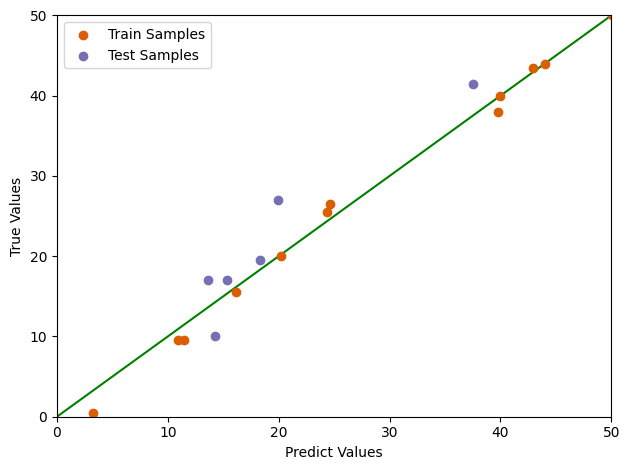

In [ ]:
# Ensemble Model without MC

# Dividing the sets of predictive attributes into two subspaces of arbitrary shape
X_treino_subconj1 = X_treino.loc[:, 'COMBUSTIVEL':'FEIJOES'] # First subset of features - top 10
X_treino_subconj2 = X_treino.loc[:, 'FRUTAS':'DIAS_PORTO_SEDE']  # Second subset of features - last 10

# Creating models for each subset
model1 = RandomForestRegressor(max_depth=3, random_state=0)
model2 = GradientBoostingRegressor(random_state=0)

# Training the models on the corresponding subsets
model1.fit(X_treino_subconj1, y_treino)
model2.fit(X_treino_subconj2, y_treino)

# Making predictions on corresponding test sets
predicoes1 = model1.predict(X_teste.loc[:, 'COMBUSTIVEL':'FEIJOES'])
predicoes2 = model2.predict(X_teste.loc[:, 'FRUTAS':'DIAS_PORTO_SEDE'])

#Ensemble Model - using VotingRegressor
Comite_s_MC = VotingRegressor([('model1', model1), ('model2', model2)])
Comite_s_MC.fit(X_treino, y_treino)

# Predictions
predicoes_Comite_treino = Comite_s_MC.predict(X_treino)  # conjunto de treino
predicoes_Comite_teste = Comite_s_MC.predict(X_teste)  # conjunto de teste

# Performance Measures
print('Comitê de Modelos sem MC')
metricas(y_treino, predicoes_Comite_treino, y_teste, predicoes_Comite_teste)
print('\n')

#### **EMBODYING**

##### Mapping Clusters Entities onto the Integrated Data of MilNavalPlatform

In [ ]:
# Rearranges the columns of the Endurance dataset
df_Endurance_Order = df_Endurance[['ANO',	'TRIMESTRE',	'COMBUSTIVEL',	'GRAXA',	'LUBRIFICANTE',	'DIAS_PORTO_FORA_SEDE',
                             'ACUCARES',	'ARROZ_MASSA',	'BEBIDAS',	'CARNES',	'FEIJOES',
                             'FRUTAS',	'LEGUMES_VERDURAS',	'LEITE_QUEIJO',	'OLEOS_GORDURAS',	'TEMPEROS',	'MILITARES',
                             'DIAS_PORTO_SEDE',	'MILHAS',	'DIAS_MAR']]
yo = df_Endurance_Order['DIAS_MAR']

XO = df_Endurance_Order.drop(['ANO', 'GRAXA', 'TRIMESTRE', 'MILHAS', 'DIAS_MAR'], axis=1)
# Separates training and testing sets
X_treino, X_teste, y_treino, y_teste = train_test_split(XO, yo, test_size=0.3, random_state=0)

In [ ]:
# Features Catergory - performs the categorization of the features

# First subset of features - represents the features that are part of the union
# between the clusters Movement, Anchored, and MooredOutHeadquarters, but are
# not present in MooredAtHeadquarters
X_treino_subconj1_mc = X_treino.loc[:, 'COMBUSTIVEL':'DIAS_PORTO_FORA_SEDE']

# Second subset of features - represents the features not present in first
# subset
X_treino_subconj2_mc = X_treino.loc[:, 'ACUCARES':'DIAS_PORTO_SEDE']

##### Train

Comitê de Modelos com MC
Coeficiente de Determinação (R²): 0.97
Raiz do Erro Quadrático Médio (RMSE): 1.87
--------------------------------------------------


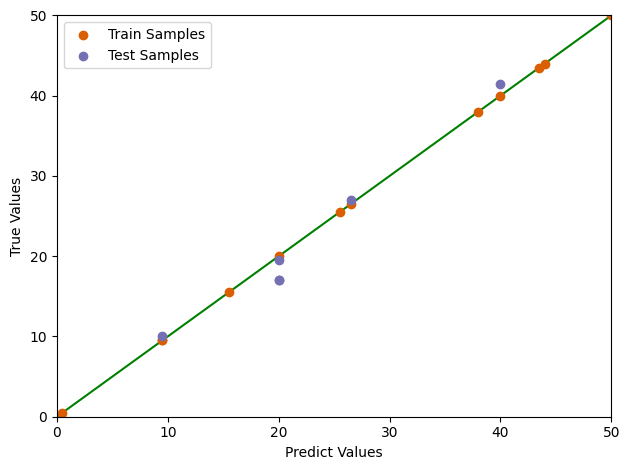

In [ ]:
# Ensemble Model with MC

# Creating models for each subset
model1 = DecisionTreeRegressor(random_state=0)
model2 = DecisionTreeRegressor(random_state=0)

# Training the models on the corresponding subsets
model1.fit(X_treino_subconj1_mc, y_treino)
model2.fit(X_treino_subconj2_mc, y_treino)

# Making predictions on corresponding test sets
# predicoes1 = model1.predict(X_teste_subconj1_mc)
# predicoes2 = model2.predict(X_teste_subconj2_mc)

# Ensemble Model using VotingRegressor
Comite_c_MC = VotingRegressor([('model1', model1), ('model2', model2)])
Comite_c_MC.fit(X_treino, y_treino)

# Predictions
precicoes_Comite_treino_c = Comite_c_MC.predict(X_treino)  # training set
predicoes_Comite_teste_c = Comite_c_MC.predict(X_teste)  # test set

# Performance Measures
print('Comitê de Modelos com MC')
metricas(y_treino, precicoes_Comite_treino_c, y_teste, predicoes_Comite_teste_c)
print('\n')

### **Using Synthetic Data**

#### **Train and Test Sets**

In [ ]:
# Separates training and testing sets
X_treino_s, X_teste_s, y_treino_s, y_teste_s = train_test_split(X_s, y_s, test_size=0.3, random_state=0)

# Normalization of predictive attributes
norm = StandardScaler()
X_treino_norm_s = norm.fit_transform(X_treino_s)
X_teste_norm_s = norm.transform(X_teste_s)

#print(X_teste_norm)
X_treino_s.head()

,COMBUSTIVEL,LUBRIFICANTE,ACUCARES,ARROZ_MASSA,BEBIDAS,CARNES,FEIJOES,FRUTAS,LEGUMES_VERDURAS,LEITE_QUEIJO,OLEOS_GORDURAS,TEMPEROS,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE
386,1.043567e+06,24995.031624,886.534808,1538.678902,255.998825,4010.134078,855.544111,388.753090,271.402264,457.577072,519.708942,230.397558,230.534860,59.088812,4.457511
391,1.043471e+06,25006.538009,889.219182,1536.210668,256.291245,4012.187087,854.924129,386.735441,271.203558,451.433798,522.402808,230.571080,230.909044,59.839059,5.312220
5,1.274619e+06,47008.747218,579.076552,1529.195349,228.823529,5353.755824,692.380952,730.516129,245.495273,477.863291,468.324324,174.777778,227.000000,32.000000,18.000000
141,1.328166e+06,49848.055935,1280.088774,2619.216559,225.427848,5424.487087,1580.746772,686.499000,222.799544,391.150962,761.498432,288.670157,221.819408,59.570492,7.658208
402,1.043599e+06,24992.253162,885.407677,1538.102838,256.541851,4008.388816,856.929065,385.983831,275.370206,454.326175,519.412743,231.134793,231.616430,60.593585,6.309347


#### **Individual Estimators**

In [ ]:
# Creating the individual models
modelo_RL = make_pipeline(preprocessing.StandardScaler(), LinearRegression())
modelo_AD = make_pipeline(DecisionTreeRegressor(random_state=0))
modelo_RF = make_pipeline(RandomForestRegressor(max_depth=3, random_state=0))
modelo_GB = make_pipeline(preprocessing.StandardScaler(), GradientBoostingRegressor(random_state=0))
modelo_KN = make_pipeline(preprocessing.StandardScaler(), KNeighborsRegressor(n_neighbors=2))
modelo_SV = make_pipeline(preprocessing.StandardScaler(), SVR(kernel='linear'))
modelo_RN = make_pipeline(preprocessing.StandardScaler(), MLPRegressor(max_iter=1000, random_state=0))

# List of pipelines
pipelines = [
    modelo_RL,
    modelo_AD,
    modelo_RF,
    modelo_GB,
    modelo_KN,
    #modelo_SV,
    #modelo_RN
]

# Training and evaluating each pipeline
for pipeline in pipelines:
    # Training the pipeline on the training set
    pipeline.fit(X_treino_s, y_treino_s)

    # Predictions - test set
    predicoes = pipeline.predict(X_teste_s)

    # Evaluating performance using R² as an example metric
    #r2 = (r2_score(y_teste, predicoes)*100)
    r2 = r2_score(y_teste_s, predicoes)
    rmse = np.sqrt(mean_squared_error(y_teste_s, predicoes))
        #mae = mean_absolute_error(y_teste, predicoes)

    # Displaying the results
    print(f'Métricas para {pipeline[-1]}')
    #print(f'Coeficiente de Determinação (R²): {r2:.2f}%')
    print(f'Coeficiente de Determinação (R²): {r2:.2f}')
    #print(f'Erro Absoluto Médio (MAE): {mae:.0f}')
    print(f'Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}')
    print('\n')

Métricas para LinearRegression()
Coeficiente de Determinação (R²): 0.65
Raiz do Erro Quadrático Médio (RMSE): 4.13


Métricas para DecisionTreeRegressor(random_state=0)
Coeficiente de Determinação (R²): 0.94
Raiz do Erro Quadrático Médio (RMSE): 1.72


Métricas para RandomForestRegressor(max_depth=3, random_state=0)
Coeficiente de Determinação (R²): 0.89
Raiz do Erro Quadrático Médio (RMSE): 2.26


Métricas para GradientBoostingRegressor(random_state=0)
Coeficiente de Determinação (R²): 0.90
Raiz do Erro Quadrático Médio (RMSE): 2.15


Métricas para KNeighborsRegressor(n_neighbors=2)
Coeficiente de Determinação (R²): 0.71
Raiz do Erro Quadrático Médio (RMSE): 3.75




#### **Ensemble Model**

In [ ]:
# Ensemble Model without MC

# Dividing the sets of predictive attributes into two subspaces of arbitrary shape
X_treino_subconj1_s = X_treino_s.loc[:, 'COMBUSTIVEL':'FEIJOES'] # First subset of features - top 10
X_treino_subconj2_s = X_treino_s.loc[:, 'FRUTAS':'DIAS_PORTO_SEDE']  # Second subset of features - last 10

# Creating models for each subset
model1 = RandomForestRegressor(max_depth=3, random_state=0)
model2 = GradientBoostingRegressor(random_state=0)

# Training the models on the corresponding subsets
model1.fit(X_treino_subconj1_s, y_treino_s)
model2.fit(X_treino_subconj2_s, y_treino_s)

# Making predictions on corresponding test sets
predicoes1 = model1.predict(X_teste_s.loc[:, 'COMBUSTIVEL':'FEIJOES'])
predicoes2 = model2.predict(X_teste_s.loc[:, 'FRUTAS':'DIAS_PORTO_SEDE'])

#Ensemble Model - using VotingRegressor
Comite_s_MC = VotingRegressor([('model1', model1), ('model2', model2)])
Comite_s_MC.fit(X_treino_s, y_treino_s)

# Predictions
predicoes_Comite_treino_s = Comite_s_MC.predict(X_treino_s)  # conjunto de treino
predicoes_Comite_teste_s = Comite_s_MC.predict(X_teste_s)  # conjunto de teste

Comitê de Modelos sem MC
Coeficiente de Determinação (R²): 0.90
Raiz do Erro Quadrático Médio (RMSE): 2.20
--------------------------------------------------


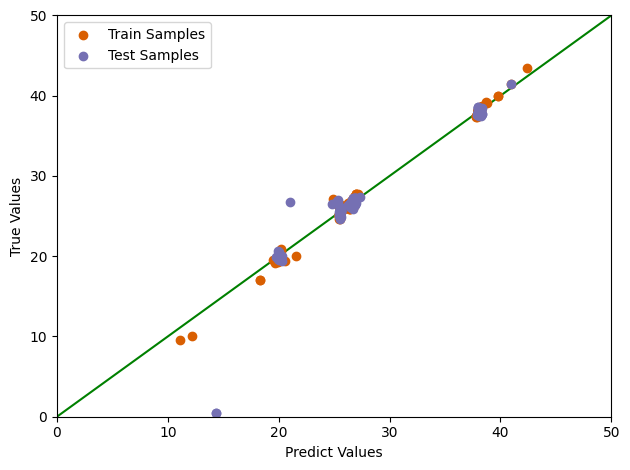

In [ ]:
# Performance Measures
print('Comitê de Modelos sem MC')
metricas(y_treino_s, predicoes_Comite_treino_s, y_teste_s, predicoes_Comite_teste_s)
print('\n')

#### **EMBODYING**

##### Mapping Group Entities onto the Integrated Data of MilNavalPlatform

In [ ]:
# Rearranges the columns of the Endurance dataset
df_Endurance_Order = df_Endurance_RO[['ANO',	'TRIMESTRE',	'COMBUSTIVEL',	'GRAXA',	'LUBRIFICANTE',	'DIAS_PORTO_FORA_SEDE',
                             'ACUCARES',	'ARROZ_MASSA',	'BEBIDAS',	'CARNES',	'FEIJOES',
                             'FRUTAS',	'LEGUMES_VERDURAS',	'LEITE_QUEIJO',	'OLEOS_GORDURAS',	'TEMPEROS',	'MILITARES',
                             'DIAS_PORTO_SEDE',	'MILHAS',	'DIAS_MAR']]
yo = df_Endurance_Order['DIAS_MAR']

XO = df_Endurance_Order.drop(['ANO', 'GRAXA', 'TRIMESTRE', 'MILHAS', 'DIAS_MAR'], axis=1)
# Separates training and testing sets
X_treino_o, X_teste_o, y_treino_o, y_teste_o = train_test_split(XO, yo, test_size=0.3, random_state=0)

In [ ]:
# Features Catergory - performs the categorization of the features

# First subset of features - represents the features that are part of the union
# between the clusters Movement, Anchored, and MooredOutHeadquarters, but are
# not present in MooredAtHeadquarters
X_treino_subconj1_o = X_treino_o.loc[:, 'COMBUSTIVEL':'DIAS_PORTO_FORA_SEDE']

# Second subset of features - represents the features not present in first
# subset
X_treino_subconj2_o = X_treino_o.loc[:, 'ACUCARES':'DIAS_PORTO_SEDE']

##### Train

Comitê de Modelos com MC
Coeficiente de Determinação (R²): 0.93
Raiz do Erro Quadrático Médio (RMSE): 1.84
--------------------------------------------------


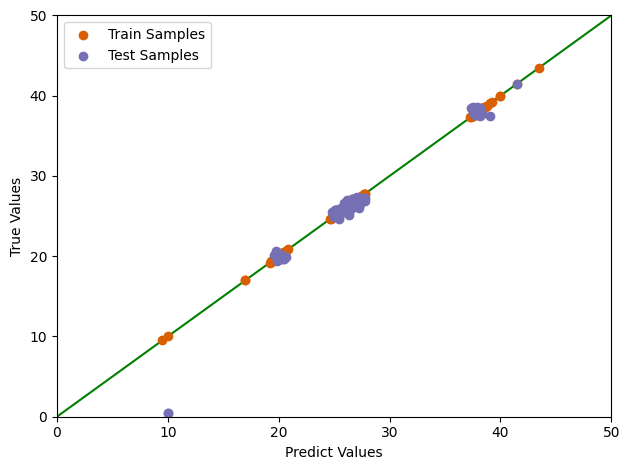

In [ ]:
# Ensemble Model with MC

# Creating models for each subset
model1 = DecisionTreeRegressor(random_state=0)
model2 = DecisionTreeRegressor(random_state=0)

# Training the models on the corresponding subsets
model1.fit(X_treino_subconj1_o, y_treino_o)
model2.fit(X_treino_subconj2_o, y_treino_o)

# Making predictions on corresponding test sets
# predicoes1 = model1.predict(X_teste_subconj1_o)
# predicoes2 = model2.predict(X_teste_subconj2_o)

# Ensemble Model using VotingRegressor
Comite_c_MC = VotingRegressor([('model1', model1), ('model2', model2)])
Comite_c_MC.fit(X_treino_o, y_treino_o)

# Predictions
precicoes_Comite_treino_c = Comite_c_MC.predict(X_treino_o)  # training set
predicoes_Comite_teste_c = Comite_c_MC.predict(X_teste_o)  # test set

# Performance Measures
print('Comitê de Modelos com MC')
metricas(y_treino_o, precicoes_Comite_treino_c, y_teste_o, predicoes_Comite_teste_c)
print('\n')

In [ ]:
%%writefile app.py
# Mock model setup (replace with actual loaded model if available)
# This is a placeholder for the Comite_c_MC ensemble
# Load your trained model here, e.g., with pickle.load()

# Creating dummy regressors to mimic the structure of the VotingRegressor
# model1 = DecisionTreeRegressor(random_state=0)
# model2 = DecisionTreeRegressor(random_state=0)
# Comite_c_MC = VotingRegressor([('model1', model1), ('model2', model2)])

# Assume models are trained. In a real implementation, load your pre-trained models.
# Comite_c_MC = pickle.load(open('path_to_your_model.pkl', 'rb'))
import streamlit as st
import pickle

# st.write("Hello World")

st.title("Predictive Model Application")

# Define input fields for each predictive attribute
st.sidebar.header("Input Features")
inputs = {}
inputs['COMBUSTIVEL'] = st.sidebar.number_input("Combustivel", min_value=0.0, value=100000.0)
inputs['LUBRIFICANTE'] = st.sidebar.number_input("Lubrificante", min_value=0.0, value=10.0)
inputs['DIAS_PORTO_FORA_SEDE'] = st.sidebar.number_input("Dias Porto Fora Sede", min_value=0, value=5)
inputs['ACUARES'] = st.sidebar.number_input("Açúcares", min_value=0.0, value=2.0)
inputs['ARROZ_MASSA'] = st.sidebar.number_input("Arroz e Massa", min_value=0.0, value=5.0)
inputs['BEBIDAS'] = st.sidebar.number_input("Bebidas", min_value=0.0, value=3.0)
inputs['CARNES'] = st.sidebar.number_input("Carnes", min_value=0.0, value=7.0)
inputs['FEIJOES'] = st.sidebar.number_input("Feijões", min_value=0.0, value=1.0)
inputs['FRUTAS'] = st.sidebar.number_input("Frutas", min_value=0.0, value=2.0)
inputs['LEGUMES_VERDURAS'] = st.sidebar.number_input("Legumes e Verduras", min_value=0.0, value=4.0)
inputs['LEITE_QUEIJO'] = st.sidebar.number_input("Leite e Queijo", min_value=0.0, value=2.0)
inputs['OLEOS_GORDURAS'] = st.sidebar.number_input("Óleos e Gorduras", min_value=0.0, value=1.0)
inputs['TEMPEROS'] = st.sidebar.number_input("Temperos", min_value=0.0, value=0.5)
inputs['MILITARES'] = st.sidebar.number_input("Militares", min_value=0, value=50)
inputs['DIAS_PORTO_SEDE'] = st.sidebar.number_input("Dias Porto Sede", min_value=0, value=10)

# Prepare input for prediction
input_array = np.array([[inputs[feature] for feature in inputs]])

# Perform prediction
if st.button("Predict"):
    # In a real scenario, this model should be pre-trained
    try:
        prediction = Comite_c_MC.predict(input_array)
        st.success(f"Predicted Value of Y: {prediction[0]:.2f}")
    except Exception as e:
        st.error(f"Error in prediction: {e}")

st.info("Ensure the model is correctly trained and loaded for accurate predictions.")

Writing app.py


In [ ]:
!npm install localtunnel

⠙⠹⠸⠼⠴⠦⠧
up to date, audited 23 packages in 1s
⠧
⠧3 packages are looking for funding
⠧  run `npm fund` for details
⠧
2 moderate severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
⠧

In [ ]:
!streamlit run opp.py &>/content/logs.txt

In [ ]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password/Enpoint IP for localtunnel is: 35.245.203.156


In [ ]:
!npx localtunnel --port 8501

⠙your url is: https://honest-rules-jam.loca.lt
^C


In [ ]:
!curl https://loca.lt/mytunnelpassword

35.245.203.156